In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('social-distancing-student')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 5

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

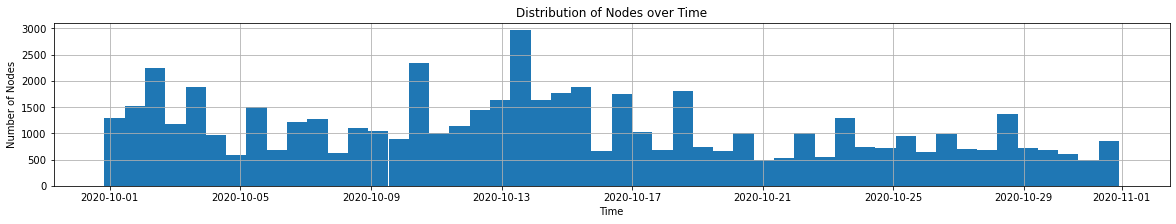

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 93433
Number of Edges: 3710183
Density: 0.0004250102382551093


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 79.41911316130275
Median Degree: 4.0


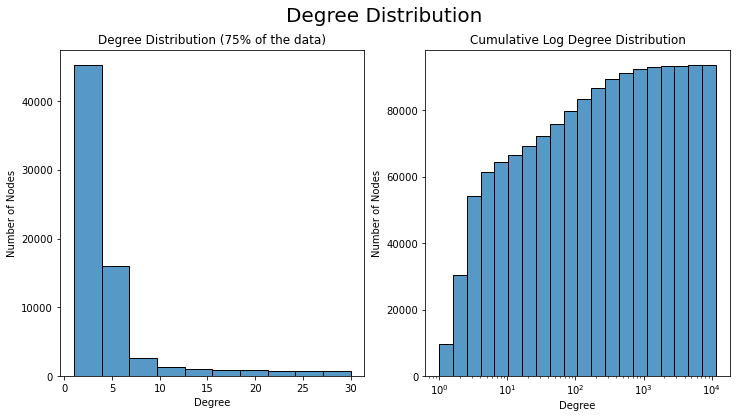

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,11505,NOS
1,11073,Mark Rutte
2,7711,RIVM
3,7670,Matthijs Pontier 💜🏴‍☠️
4,7456,NU.nl
5,7108,de Volkskrant
6,7056,RTL Nieuws
7,6988,Thierry Baudet
8,6845,Wierd Duk
9,6563,Maurice de Hond


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.302
Diameter: 15


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,92828.000000,9.282800e+04,9.282800e+04,92828.000000,82458.000000
mean,0.000688,2.635559e-05,9.327505e-04,0.000011,0.338164
std,0.002476,9.675662e-04,3.146855e-03,0.000031,0.352957
min,0.000011,0.000000e+00,2.292513e-21,0.000002,0.000000
25%,0.000022,0.000000e+00,4.537200e-06,0.000002,0.000000
50%,0.000032,3.204936e-09,3.081323e-05,0.000004,0.234477
75%,0.000312,5.386480e-06,3.225603e-04,0.000008,0.499552
max,0.121678,2.002553e-01,6.207933e-02,0.002366,1.000000


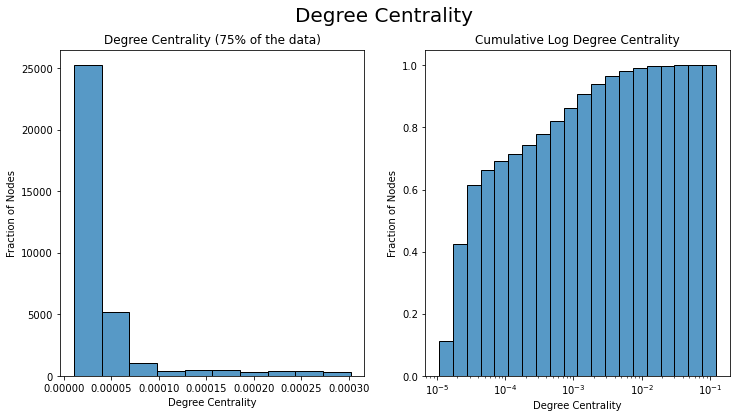

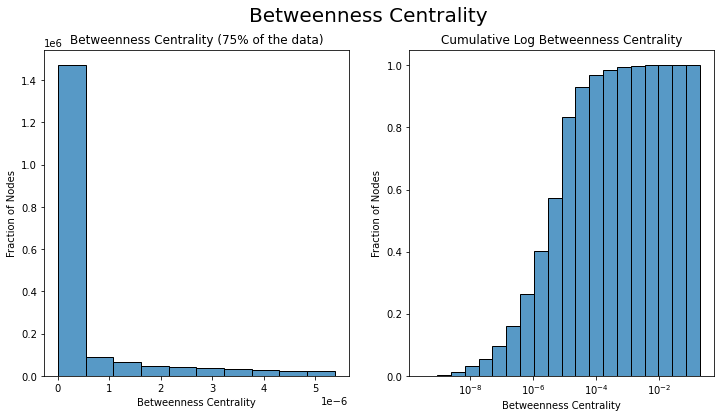

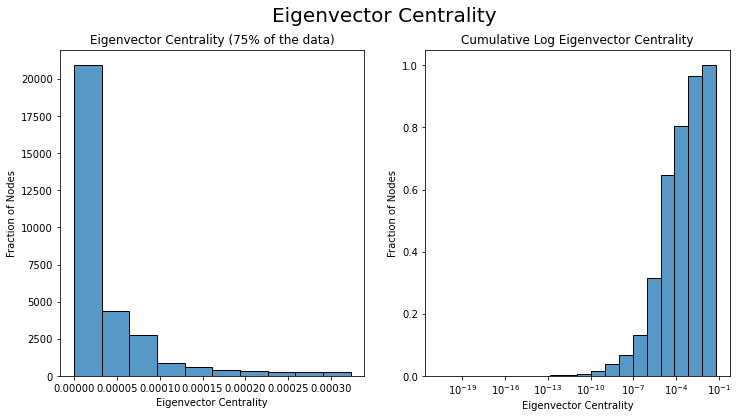

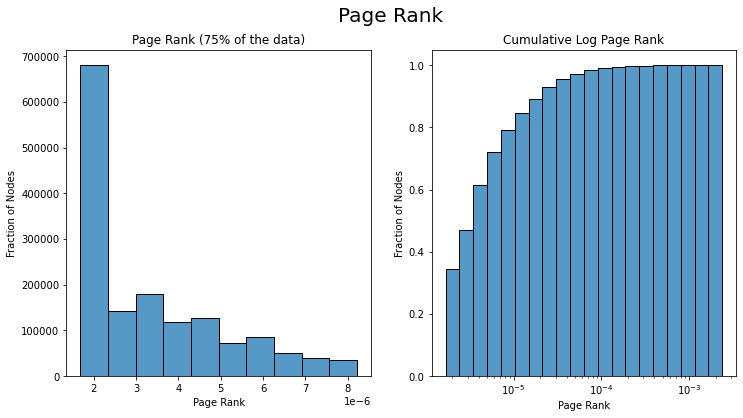

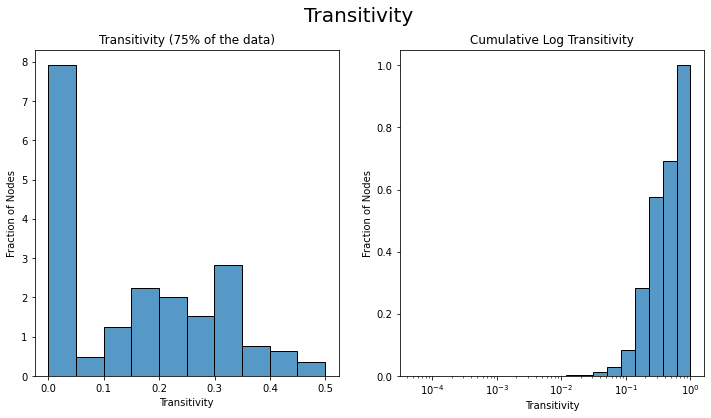

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.121678,NOS,0.200255,Victor Hopman,0.062079,Thierry Baudet,0.002366,Mark Rutte,1.0,RT @cipnl: Volgens prof. Nederveen laat de nie...
1,0.117520,Mark Rutte,0.181164,Marten Visser,0.056700,Wierd Duk,0.002314,NOS,1.0,RT @EuWaanzin: De mondkapjes deugneuzen gaan h...
2,0.081690,RIVM,0.056173,Mark Rutte,0.053949,NOS,0.001378,Maurice de Hond,1.0,"RT @KarinSpaink: Alleen afstand houden, alleen..."
3,0.079600,NU.nl,0.046064,Wierd Duk,0.053103,Ebru Umar #1,0.001359,RIVM,1.0,RT @mauricedehond: ”Onze maatregelen (handen s...
4,0.075549,de Volkskrant,0.030795,Hugo de Jonge,0.050931,Maurice de Hond,0.001283,Marc Van Ranst,1.0,RT @harryhol: Wat mij enorm frustreert: als we...
5,0.074806,Thierry Baudet,0.027788,Nieuwsuur,0.050725,Sietske Bergsma,0.001254,NU.nl,1.0,@ashatenbroeke @KarinSpaink met mondkapjes en ...
6,0.074461,RTL Nieuws,0.025821,Sander de Hosson,0.050608,Matthijs Pontier 💜🏴‍☠️,0.001205,Hugo de Jonge,1.0,@nootjes_ladieda Het is zooooo lastig allemaal...
7,0.069721,Maurice de Hond,0.025027,Op1,0.050463,Mark Rutte,0.001155,RTL Nieuws,1.0,RT @Fgandoul: Dan hou je je als restauranthoud...
8,0.069107,Nieuwsuur,0.024863,NOS,0.050386,Martin Bos,0.001142,De Telegraaf,1.0,RT @Momootjem: Bij deze:\nIk draag geen mondka...
9,0.068094,Follow the Money,0.022328,RT @shossontwits: De grenzen van de zorg komen...,0.048908,Jan Dijkgraaf,0.001060,Tim Hofman,1.0,@ServaasStoop Nu denken we bij zo'n foto gelij...


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 245
Size of the largest component: 92828


Text(0.5, 1.0, 'Connected Components')

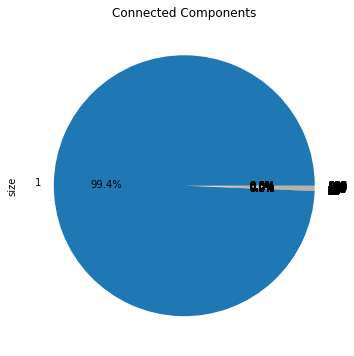

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 3


,type,count,degree_avg,degree_median
Hashtag,Hashtag,2341,5.259718,1.0
Tweet,Tweet,56173,2.951596,3.0
User,User,34919,207.401501,69.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

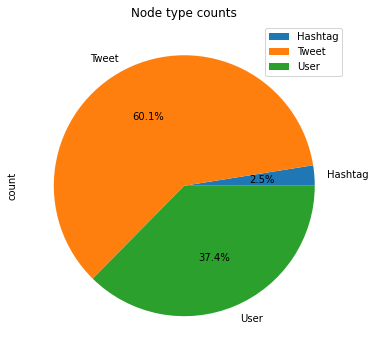

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

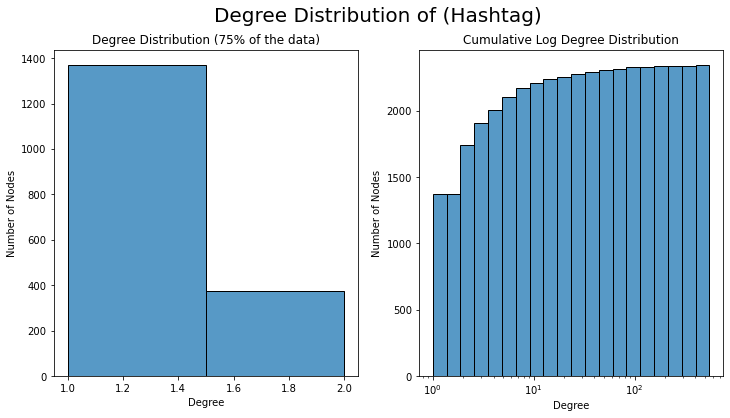

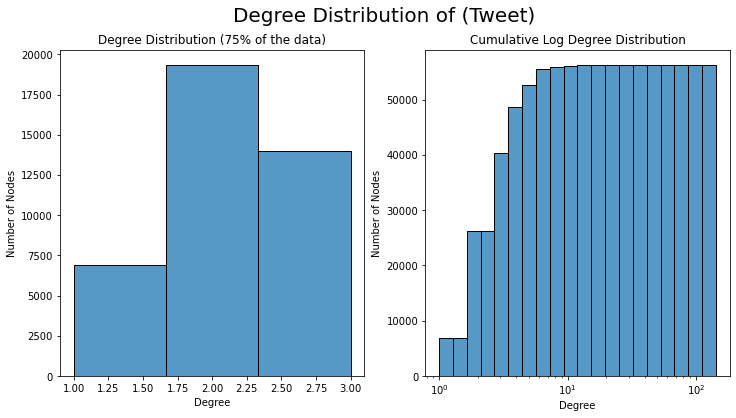

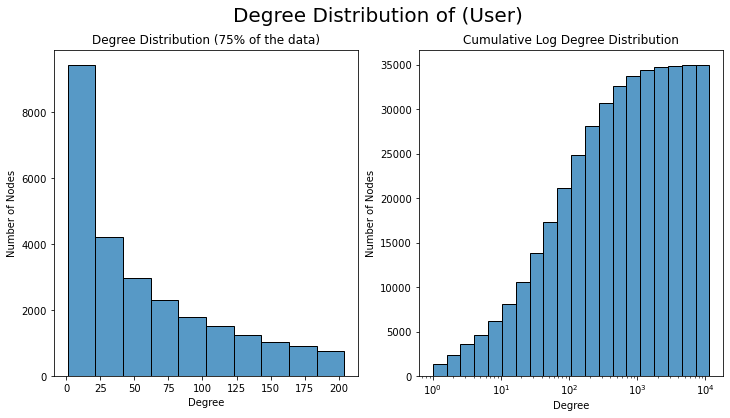

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Hashtag)


,value,label
0,552,anderhalvemeter
1,413,coronamaatregelen
2,389,mondkapjes
3,340,mondkapje
4,279,coroNEE
5,223,coronavirus
6,208,Covid19
7,193,anderhalvemeterdictatuur
8,178,corona
9,150,Corona


Top 10 Degree Nodes of Type (Tweet)


,value,label
0,143,"@vanbinnenblauw @lisette1100 Hoi, het is belan..."
1,59,"Volgens collega Wilders is de 1,5 meter-regel ..."
2,34,"HOUD 1,5 METER AFSTAND. WAS JE HANDEN STUK. LA..."
3,29,#JAGERS #KRIMPENERWAARD OVERTREDEN #CORONA REG...
4,28,Houden ons aan de regels zoals deze vandaag ge...
5,22,"""de coronamaatregelen zijn strikt nageleefd. [..."
6,21,Draag een mondkapje in publiek toegankelijke b...
7,21,RedTeam luidt alarmbellen: ’Leerlingen voortge...
8,16,"Mijn oom heeft corona en is besmettelijk, maar..."
9,16,"@peter_persyn @De7deDag Beste, bedankt voor de..."


Top 10 Degree Nodes of Type (User)


,value,label
0,11505,NOS
1,11073,Mark Rutte
2,7711,RIVM
3,7670,Matthijs Pontier 💜🏴‍☠️
4,7456,NU.nl
5,7108,de Volkskrant
6,7056,RTL Nieuws
7,6988,Thierry Baudet
8,6845,Wierd Duk
9,6563,Maurice de Hond


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 7


,type,count
FOLLOWS,FOLLOWS,3546972
MENTIONS_HASHTAG,MENTIONS_HASHTAG,12313
MENTIONS_USER,MENTIONS_USER,70367
QUOTES_TWEET,QUOTES_TWEET,441
REPLIES_TO_TWEET,REPLIES_TO_TWEET,2148
REPLIES_TO_USER,REPLIES_TO_USER,21769
TWEETED,TWEETED,56173


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

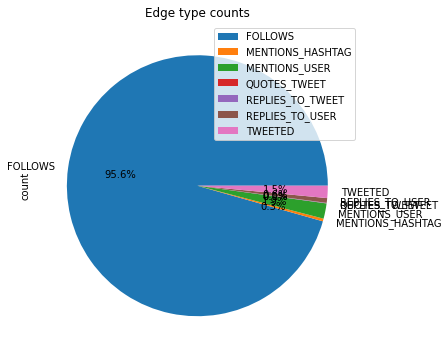

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Hashtag


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.005947,anderhalvemeter,0.000585,coronamaatregelen,0.000021,anderhalvemeter,0.000534,anderhalvemeter,1.000000,Ikhebeenmondkapje
1,0.004449,coronamaatregelen,0.000491,anderhalvemeter,0.000017,mondkapjes,0.000389,coronamaatregelen,0.333333,hoekvanholland
2,0.004191,mondkapjes,0.000343,coroNEE,0.000015,Covid19,0.000328,mondkapjes,0.166667,deanderhalvemetershow
3,0.003663,mondkapje,0.000160,blijfthuis,0.000015,coronavirus,0.000324,mondkapje,0.100000,leerlingen
4,0.003006,coroNEE,0.000148,mondkapjes,0.000013,coronamaatregelen,0.000207,coroNEE,0.047619,CoronaApp
5,0.002402,coronavirus,0.000142,anderhalvemeterdictatuur,0.000011,stemmingmakerij,0.000198,corona,0.022222,Covid1984
6,0.002241,Covid19,0.000136,mondkapje,0.000006,BOA,0.000193,coronavirus,0.001587,HetkanallemaalinTwente
7,0.002079,anderhalvemeterdictatuur,0.000128,mondkapjesplicht,0.000006,mondkapje,0.000159,Corona,0.001587,VermijdDrukte
8,0.001918,corona,0.000122,corona,0.000006,Sneek,0.000157,Covid19,0.001347,freethepeople
9,0.001616,Corona,0.000118,persconferentie,0.000006,Alcoholverbod,0.000150,blijfthuis,0.001282,HoudAfstand


Top 10 Nodes by Statistic for Tweet


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001530,"@vanbinnenblauw @lisette1100 Hoi, het is belan...",0.022328,RT @shossontwits: De grenzen van de zorg komen...,0.000479,RT @Peetlief: @FlavioPasquino @hugodejonge @ri...,0.000098,"@vanbinnenblauw @lisette1100 Hoi, het is belan...",1.0,Los van een standpunt ten aanzien van scholen ...
1,0.000636,"Volgens collega Wilders is de 1,5 meter-regel ...",0.010349,@liekelamb @vic23 Ook als ik wandel in het bos...,0.000476,@FlavioPasquino @hugodejonge @rivm @MinPres @m...,0.000050,"Volgens collega Wilders is de 1,5 meter-regel ...",1.0,RT @nevobo: Sinds 14 oktober is het voor volwa...
2,0.000366,"HOUD 1,5 METER AFSTAND. WAS JE HANDEN STUK. LA...",0.007991,@vic23 In mijn supermarkt gedragen de 'boomers...,0.000431,@hugodejonge @MinPres @thierrybaudet @geertwil...,0.000031,"HOUD 1,5 METER AFSTAND. WAS JE HANDEN STUK. LA...",1.0,"RT @WybrenvanHaga: De 1,5 meter regel is volko..."
3,0.000312,#JAGERS #KRIMPENERWAARD OVERTREDEN #CORONA REG...,0.006601,RT @vic23: En toch zie ik in de horeca meer me...,0.000398,@BestNr7 @NPO1 @NOS @MinPres @rivm @ZEMBLA @vo...,0.000024,#JAGERS #KRIMPENERWAARD OVERTREDEN #CORONA REG...,1.0,RT @D66Rijswijk: Vanavond komt de Raad weer bi...
4,0.000291,Houden ons aan de regels zoals deze vandaag ge...,0.005348,RT @vic23: En toch zie ik in de horeca meer me...,0.000396,@harry59degroot @FlavioPasquino @GemkeConny @r...,0.000023,Houden ons aan de regels zoals deze vandaag ge...,1.0,@nootjes_ladieda Het is zooooo lastig allemaal...
5,0.000237,"""de coronamaatregelen zijn strikt nageleefd. [...",0.005338,RT @vic23: En toch zie ik in de horeca meer me...,0.000396,@fritsander @FlavioPasquino @GemkeConny @rivm ...,0.000021,#Schilderworkshop Joke #Krul za. 21 &amp; 28 n...,1.0,@moeva18 Het is verwarring alom. Het ene land ...
6,0.000226,RedTeam luidt alarmbellen: ’Leerlingen voortge...,0.005099,RT @vic23: En toch zie ik in de horeca meer me...,0.000395,@fritsander @FlavioPasquino @GemkeConny @rivm ...,0.000021,#coronamaatregelen #blijfthuis #amsterdam #rot...,1.0,RT @rivm: Het is belangrijk om zoveel mogelijk...
7,0.000226,Draag een mondkapje in publiek toegankelijke b...,0.004645,RT @vic23: En toch zie ik in de horeca meer me...,0.000395,@harry59degroot @FlavioPasquino @GemkeConny @r...,0.000021,RT @rayklaassen: ANDERHALVE METER SESSIES\n\nB...,1.0,@FonAeris Ja idd. Ik had laatst een klant uit ...
8,0.000172,"Mijn oom heeft corona en is besmettelijk, maar...",0.004347,RT @suusonline: @vic23 🙂 Ik ook! Hield me alti...,0.000321,RT @BobVeritas: @hommel_b @mariannezw 🤣 Colleg...,0.000021,1.5 met vn elkaar...vandaag met Steam @j.marte...,1.0,RT @spoedz: Kom op mensen!!\nHoudt je aan de r...
9,0.000162,"@peter_persyn @De7deDag Beste, bedankt voor de...",0.004104,@Jan_oprecht_s @vic23 @joey_belt en toch is he...,0.000318,@Peetlief @DeRedacteur_ @MinPres @hugodejonge ...,0.000020,#BlijfGezond #BlijfBewegen #HoudtAfstand #Weer...,1.0,RT @vrnhn: Draag een mondkapje in publiek toeg...


Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.121678,NOS,0.200255,Victor Hopman,0.062079,Thierry Baudet,0.002366,Mark Rutte,1.0,Fridays For Future Nettetal
1,0.117520,Mark Rutte,0.181164,Marten Visser,0.056700,Wierd Duk,0.002314,NOS,1.0,Marit
2,0.081690,RIVM,0.056173,Mark Rutte,0.053949,NOS,0.001378,Maurice de Hond,1.0,Hafsa
3,0.079600,NU.nl,0.046064,Wierd Duk,0.053103,Ebru Umar #1,0.001359,RIVM,1.0,Jasper Vos
4,0.075549,de Volkskrant,0.030795,Hugo de Jonge,0.050931,Maurice de Hond,0.001283,Marc Van Ranst,1.0,mia
5,0.074806,Thierry Baudet,0.027788,Nieuwsuur,0.050725,Sietske Bergsma,0.001254,NU.nl,1.0,Helaas pindakaas 💖💖
6,0.074461,RTL Nieuws,0.025821,Sander de Hosson,0.050608,Matthijs Pontier 💜🏴‍☠️,0.001205,Hugo de Jonge,1.0,Fabian Lelo
7,0.069721,Maurice de Hond,0.025027,Op1,0.050463,Mark Rutte,0.001155,RTL Nieuws,1.0,𝙨𝙡𝙚𝙚𝙥 𝙙𝙚𝙥𝙧𝙞𝙫𝙚𝙙
8,0.069107,Nieuwsuur,0.024863,NOS,0.050386,Martin Bos,0.001142,De Telegraaf,1.0,Jordy Coulier
9,0.068094,Follow the Money,0.019642,EenVandaag,0.048908,Jan Dijkgraaf,0.001060,Tim Hofman,1.0,𝒟𝒶𝓃𝓃𝓎𝒾𝑜𝑜𝑜


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 1.1102230246251565e-16


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.42793364858454636
Number of communities: 439


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

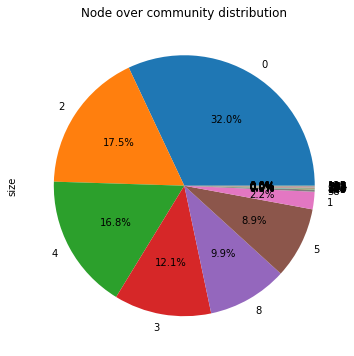

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.121678,NOS,0.181164,Marten Visser,0.053949,NOS,0.002366,Mark Rutte,1.0,RT @MinVWS: Draag een mondkapje in publiek toe...
1,0.117520,Mark Rutte,0.056173,Mark Rutte,0.050463,Mark Rutte,0.002314,NOS,1.0,RT @MinPres: Draag een mondkapje in publiek to...
2,0.081690,RIVM,0.030795,Hugo de Jonge,0.046740,Follow the Money,0.001359,RIVM,1.0,RT @gem_apeldoorn: Een klein gebaar kan het ve...
3,0.079600,NU.nl,0.027788,Nieuwsuur,0.046476,Saskia Belleman,0.001254,NU.nl,1.0,RT @djidee: Het is gewoon een feit. Niet medis...
4,0.075549,de Volkskrant,0.025027,Op1,0.044484,RTL Nieuws,0.001205,Hugo de Jonge,1.0,RT @VrZW: Draag een mondkapje in publiek toega...
5,0.074461,RTL Nieuws,0.024863,NOS,0.043964,De Telegraaf,0.001155,RTL Nieuws,1.0,@Stan__G Nee nog niet zo trainen! Met 4 man en...
6,0.069107,Nieuwsuur,0.019642,EenVandaag,0.042455,Nieuwsuur,0.001142,De Telegraaf,1.0,@RBaruch We zitten op meer dan 1.5 meter afsta...
7,0.068094,Follow the Money,0.019003,kees van geenhuizen,0.041637,de Volkskrant,0.001060,Tim Hofman,1.0,@Stan__G Nee nog niet zo trainen! Met 4 man en...
8,0.067836,Hugo de Jonge,0.018514,de Volkskrant,0.037725,Bas Paternotte,0.000988,de Volkskrant,1.0,RT @MinPres: Draag een mondkapje in publiek to...
9,0.065283,De Telegraaf,0.014112,RIVM,0.037688,NU.nl,0.000946,Nieuwsuur,1.0,@BrendaStoter Dat geblunder is dan wel geblund...


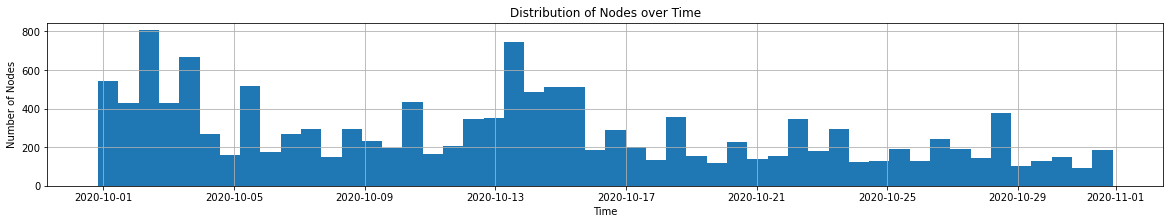

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.012906,Efteling,0.200255,Victor Hopman,0.004591,Efteling,0.000267,Efteling,1.0,@janine_leroy Onze baas wilt het niet verplich...
1,0.004180,Looopings,0.022328,RT @shossontwits: De grenzen van de zorg komen...,0.003347,Henk Jan,0.000257,Victor Hopman,1.0,@Neraajz Nauwe contacten van 3*\n\nDat beteken...
2,0.002456,Henk Jan,0.007991,@vic23 In mijn supermarkt gedragen de 'boomers...,0.002943,Sanne van Galen,0.000103,Looopings,1.0,@ThemeTalkNL Pretparken waar je met veel moeit...
3,0.002262,Sanne van Galen,0.006601,RT @vic23: En toch zie ik in de horeca meer me...,0.001884,Joey,0.000070,M⁷☆,1.0,@wildflowerlando Ja wij moeten ook een mondkap...
4,0.001971,Victor Hopman,0.005348,RT @vic23: En toch zie ik in de horeca meer me...,0.001855,Cemal,0.000066,Team Looopings,1.0,Hazed$
5,0.001961,David Harms 🌈,0.005338,RT @vic23: En toch zie ik in de horeca meer me...,0.001610,lynn,0.000061,ThemeTalk,1.0,@MarijnHogenkamp Ben nu bitter teleurgesteld d...
6,0.001842,Kleine Boodschap,0.005099,RT @vic23: En toch zie ik in de horeca meer me...,0.001542,Marc,0.000060,David Harms 🌈,1.0,"@DdgAlyssa 1,5 meter is voldoende"
7,0.001788,Maxim De Donder,0.004645,RT @vic23: En toch zie ik in de horeca meer me...,0.001429,Looopings,0.000055,Joost Bouhof 🎭 ʲᵒᵒˢᵗˣʳᵒᵉᵈᶦᵉ•ⁿˡ,1.0,"@ZeebraOnTour Sterkte, als er iets is kan je a..."
8,0.001724,ThemeTalk,0.003904,RT @vic23: En toch zie ik in de horeca meer me...,0.001218,David,0.000054,ᴮᴱNikita⁷ maskertje op,1.0,"@POL_DenHaag Laat me raden, geen 1,5 meter en ..."
9,0.001702,lynn,0.003708,RT @vic23: En toch zie ik in de horeca meer me...,0.001155,Sergio Harinck,0.000051,Love you,1.0,RT @moonieminjoonie: Deze foto's zijn vandaag ...


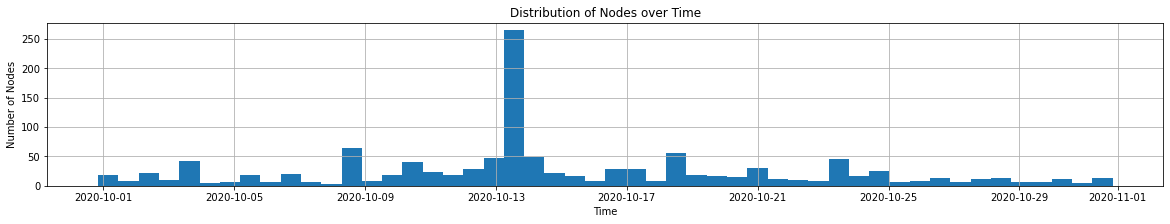

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.055243,Matthijs Pontier 💜🏴‍☠️,0.025821,Sander de Hosson,0.050608,Matthijs Pontier 💜🏴‍☠️,0.000839,Sander de Hosson,1.0,@Sham_Ahmed_ Ze zijn niet alleen lid van Faceb...
1,0.052625,Sander de Hosson,0.005388,Hendrik-Jan Derksen,0.030148,Sander de Hosson,0.000649,Chris Klomp,1.0,RT @Gervanderveen: Gevaarlijke berichtgeving o...
2,0.051235,Chris Klomp,0.004267,Matthijs Pontier 💜🏴‍☠️,0.026546,Chris Klomp,0.000614,Matthijs Pontier 💜🏴‍☠️,1.0,RT @advocaatsmeets: Thierry Baudet demonstreer...
3,0.044265,Emine Ugur,0.003834,Marino van Zelst 🌱,0.025146,Hoofdzuster,0.000545,Bert Slagter,1.0,"@Fromdamountain Probleem komt bekend voor, zek..."
4,0.040753,Marion Koopmans,0.003811,@FatimaWillems19,0.024459,Bert Slagter,0.000527,Emine Ugur,1.0,@Donkerwoud @haatheks je moet niet midden op d...
5,0.039148,Marino van Zelst 🌱,0.003719,Ayrienie vL #ikdoewelmee 🤍❤️🤍🎌,0.024452,Cees van Die,0.000523,Marion Koopmans,1.0,@SDicht Oja de besmettingen zijn verspreid ove...
6,0.039073,Bert Slagter,0.003593,Maarten Keulemans,0.023958,Brenda Stoter Boscolo بريندا,0.000521,Jelmer Visser,1.0,RT @marcelbar8: De tuin van 't Witte Huis blij...
7,0.033999,"Diederik ""Good Cop"" Jekel",0.002580,Jelmer Visser,0.023344,Marion Koopmans,0.000498,Marino van Zelst 🌱,1.0,RT @marcelbar8: De tuin van 't Witte Huis blij...
8,0.032986,Maarten Keulemans,0.002391,Hartblik John. Show your heart.,0.023325,Marino van Zelst 🌱,0.000484,Ginny Mooy,1.0,RT @marcelbar8: De tuin van 't Witte Huis blij...
9,0.032598,Jelmer Visser,0.002278,Childfreelife2,0.023102,Myrthe Hilkens,0.000462,"Diederik ""Good Cop"" Jekel",1.0,"@MENEERDEGREEF Ik wil dit ook wel, een dikke P..."


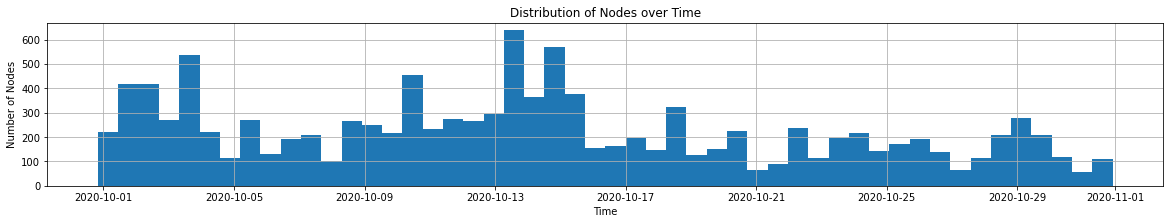

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.058938,Marc Van Ranst,0.012538,Marc Van Ranst,0.021568,Lambrechts Emiel,0.001283,Marc Van Ranst,1.0,@wouter_lefebvre Dan heb je nog altijd de opti...
1,0.020834,HLN.BE,0.005998,Fouad Gandoul,0.021256,Vincent,0.000821,Fouad Gandoul,1.0,imran_khan15
2,0.019714,De Morgen,0.003333,HLN.BE,0.020357,Marc Van Ranst,0.000414,HLN.BE,1.0,RT @vanranstmarc: Bekijk graag deze video.\nDi...
3,0.019531,Arbiter,0.001910,PJ Van Leemputten,0.018291,misterdoom,0.000318,Joël De Ceulaer,1.0,@HeiPeter Wegens het dragen van mondmasker en ...
4,0.018561,Joël De Ceulaer,0.001828,De Morgen,0.016545,Maria Vanlommel,0.000310,De Morgen,1.0,@Karinvr066 Waarom niet tijdelijk de café’s ex...
5,0.018551,Knack,0.001573,Arbiter,0.015509,Erik De Wilde,0.000278,CrisisCenter Belgium,1.0,RT @Hans_VR: “Een gezin mag thuis nog maximaal...
6,0.017064,N-VA,0.001548,Joël De Ceulaer,0.014900,Armand Vervaeck🎗️,0.000278,Sammy Mahdi,1.0,RT @rob_televisie: Luid zingen en schermutseli...
7,0.016148,CrisisCenter Belgium,0.001475,Knack,0.014765,K. Le Bato,0.000270,Arbiter,1.0,RT @vanranstmarc: Bekijk graag deze video.\nDi...
8,0.016094,Assita Kanko MEP,0.001474,NMBS,0.014666,Assita Kanko MEP,0.000269,sporza,1.0,RT @rob_televisie: Luid zingen en schermutseli...
9,0.015524,Jan Jambon,0.001343,CrisisCenter Belgium,0.014367,FreKo,0.000262,Knack,1.0,RT @vanranstmarc: Bekijk graag deze video.\nDi...


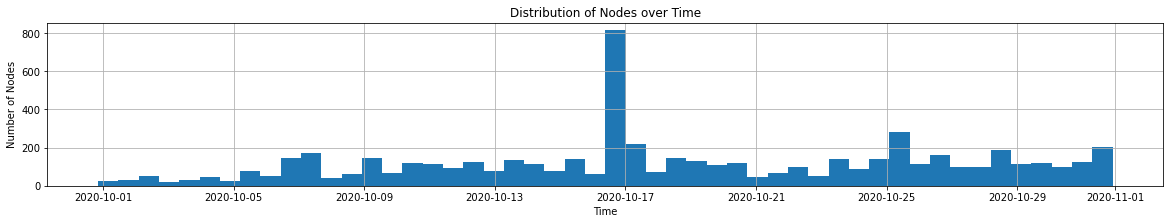

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.074806,Thierry Baudet,0.046064,Wierd Duk,0.062079,Thierry Baudet,0.001378,Maurice de Hond,1.0,RT @mauricedehond: ”Onze maatregelen (handen s...
1,0.069721,Maurice de Hond,0.012388,Maurice de Hond,0.056700,Wierd Duk,0.001040,Thierry Baudet,1.0,RT @NEETEGENMSM1: Waarom is er zo weinig ‘verz...
2,0.063796,Wierd Duk,0.008500,De Kwademan,0.053103,Ebru Umar #1,0.000991,Wybren van Haga,1.0,@dijkhoff Kijk naar Noorwegen en Zwedende.Daar...
3,0.048962,Wybren van Haga,0.008328,Thierry Baudet,0.050931,Maurice de Hond,0.000768,Wierd Duk,1.0,RT @omroepbrabant: Briljante actie: Café plaat...
4,0.048036,Ebru Umar #1,0.008119,Henk,0.050725,Sietske Bergsma,0.000598,Fleur Agema,1.0,"RT @WybrenvanHaga: De 1,5 meter regel is volko..."
5,0.046463,Jan Dijkgraaf,0.007035,Wybren van Haga,0.050386,Martin Bos,0.000595,Criticaster1960,1.0,admin@germanbunkers
6,0.045461,Sietske Bergsma,0.006749,Black is blank. Niet wit.,0.048908,Jan Dijkgraaf,0.000546,Annelies,1.0,@NOS klassen oorlog\n\nieder met een pluche ba...
7,0.045396,Fleur Agema,0.005636,The Right Sound,0.048689,ZilteHond ☀️,0.000530,Marianne Zwagerman,1.0,RT @mauricedehond: ”Onze maatregelen (handen s...
8,0.042908,Marianne Zwagerman,0.005430,Arthur van Amerongen,0.048643,Fleur Agema,0.000529,Jan Dijkgraaf,1.0,"RT @WybrenvanHaga: De 1,5 meter regel is volko..."
9,0.042305,Joost Niemoller,0.004751,Greta Eradus,0.048504,John Zuyderduyn,0.000515,Ebru Umar #1,1.0,"@ThomasInLeiden Beste Thomas, ik hou me aan al..."


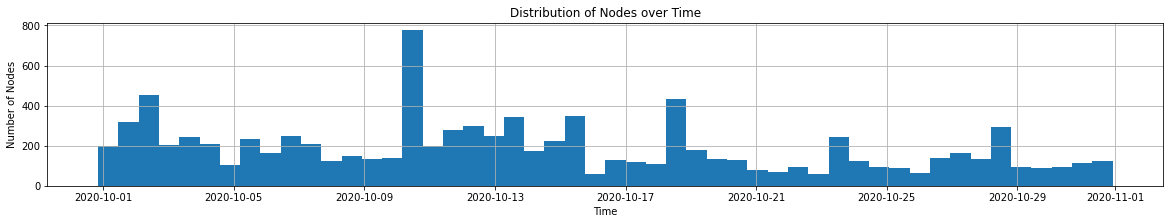

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.039633,Karel Tiberius N⭕ ⭕itgedacht,0.007689,twopcharts_nl,0.037715,Vester71,0.000416,Karel Tiberius N⭕ ⭕itgedacht,1.0,@muisje_eliza Ben blij dat ik in een dorp woon...
1,0.034979,#Ingeborgvraagt🍀😇,0.005407,Susanne,0.034302,Karel Tiberius N⭕ ⭕itgedacht,0.000384,#Ingeborgvraagt🍀😇,1.0,@JFrijling Inmiddels gaat het ook in met name ...
2,0.033848,Erwin Witteveen,0.004347,RT @suusonline: @vic23 🙂 Ik ook! Hield me alti...,0.034162,#Ingeborgvraagt🍀😇,0.000376,twopcharts_nl,1.0,"@lll_greece Nee gewoon op 1,5 mtr afstand op k..."
3,0.033805,twopcharts_nl,0.003681,#Ingeborgvraagt🍀😇,0.033567,Erwin Witteveen,0.000368,Don Roelofsen,1.0,@jolandamahieu @dinopenotti Met zo'n grote sto...
4,0.031446,Vester71,0.003033,Paul,0.028210,📸Miss Filter💄🤳🏼,0.000354,Boswachter Tim,1.0,"@fruitpipcindy Afstandhouden, geen handen geve..."
5,0.030422,Boswachter Tim,0.002920,Nicole van Eijck ｯ,0.027776,Richard,0.000343,Remco,1.0,@Cryptopixels Het is niet moeilijk.\n Afstand ...
6,0.028688,Don Roelofsen,0.002513,Marc,0.026736,twopcharts_nl,0.000329,Erwin Witteveen,1.0,RT @MaggieBonaire: Hier op Bonaire gaat het nu...
7,0.028494,Korreltje zout!,0.002505,Remco,0.025492,Chanarchist 💫,0.000326,Koningin Máxima🔸,1.0,"Klets niet Johan, heb genoeg horeca gezien waa..."
8,0.025801,Koningin Máxima🔸,0.002300,Ellinore,0.024394,Tolerance2021 🇳🇱 🌈 ⚽,0.000325,Korreltje zout!,1.0,@Ing12474 Niet fijn hè. Maar idd afstand houde...
9,0.024120,Tolerance2021 🇳🇱 🌈 ⚽,0.002256,Arjen Douwes ✪,0.023592,Korreltje zout!,0.000303,Vester71,1.0,@Sjantal Opzich heb je een punt maar het begin...


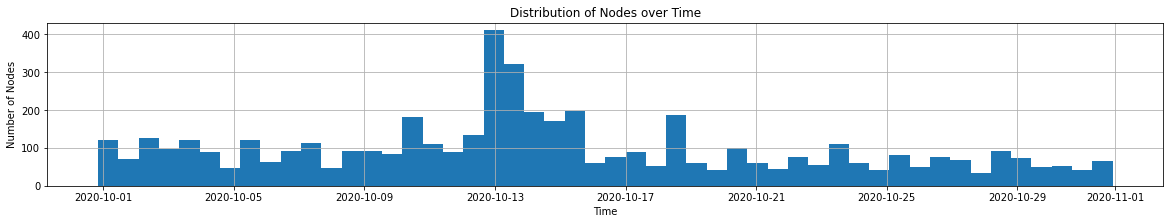

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.36648080874535566
Number of communities: 315


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

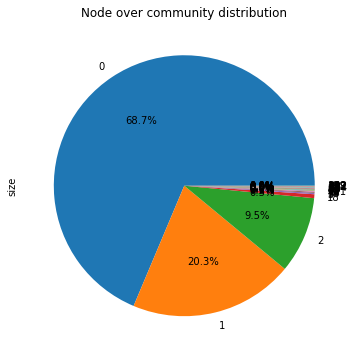

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.121678,NOS,0.181164,Marten Visser,0.056700,Wierd Duk,0.002366,Mark Rutte,1.0,"RT @ditishetnieuws: ""Nederland heeft voor ons ..."
1,0.117520,Mark Rutte,0.056173,Mark Rutte,0.053949,NOS,0.002314,NOS,1.0,@astridislief Omdat dat volgens het @rivm prim...
2,0.081690,RIVM,0.046064,Wierd Duk,0.050931,Maurice de Hond,0.001378,Maurice de Hond,1.0,RT @NadineHoog: Gisteren zat ik in de kerk met...
3,0.079600,NU.nl,0.030795,Hugo de Jonge,0.050608,Matthijs Pontier 💜🏴‍☠️,0.001359,RIVM,1.0,"RT @kutheks: de overheid sluit die mensen op, ..."
4,0.075549,de Volkskrant,0.027788,Nieuwsuur,0.050463,Mark Rutte,0.001283,Marc Van Ranst,1.0,@martijnagema Bioscopen is het goed geregeld e...
5,0.074461,RTL Nieuws,0.025821,Sander de Hosson,0.048908,Jan Dijkgraaf,0.001254,NU.nl,1.0,@IkNet Gommers: Het is eigenlijk heel duidelij...
6,0.069721,Maurice de Hond,0.025027,Op1,0.046740,Follow the Money,0.001205,Hugo de Jonge,1.0,"@GerardAdelaar @hugodejonge Dat is waar, maar ..."
7,0.069107,Nieuwsuur,0.024863,NOS,0.046476,Saskia Belleman,0.001155,RTL Nieuws,1.0,RT @Jongderik: In verreweg de meeste kerken is...
8,0.068094,Follow the Money,0.019642,EenVandaag,0.044484,RTL Nieuws,0.001142,De Telegraaf,1.0,"RT @ginnymooy: Testen, testen, testen? Kan nie..."
9,0.067836,Hugo de Jonge,0.019003,kees van geenhuizen,0.043964,De Telegraaf,0.001060,Tim Hofman,1.0,RT @Nieuwsuur: Op zeker 342 van de 648 Nederla...


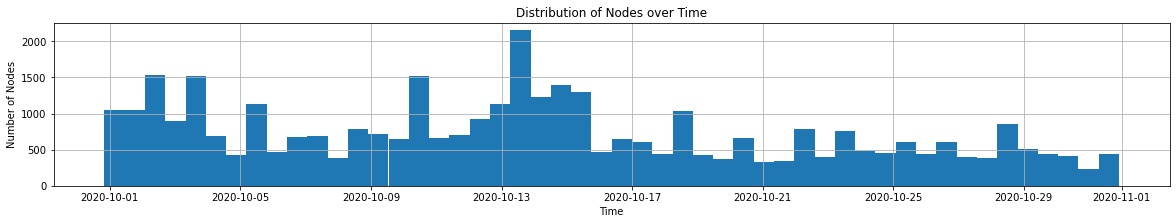

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.074806,Thierry Baudet,0.008500,De Kwademan,0.062079,Thierry Baudet,0.001040,Thierry Baudet,1.0,RT @Holavista: Anti-aanraakbeleid en afstand h...
1,0.048962,Wybren van Haga,0.008328,Thierry Baudet,0.053103,Ebru Umar #1,0.000991,Wybren van Haga,1.0,RT @MinPres: Draag een mondkapje in publiek to...
2,0.048036,Ebru Umar #1,0.008119,Henk,0.050725,Sietske Bergsma,0.000598,Fleur Agema,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
3,0.045461,Sietske Bergsma,0.007035,Wybren van Haga,0.050386,Martin Bos,0.000595,Criticaster1960,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
4,0.045396,Fleur Agema,0.006749,Black is blank. Niet wit.,0.048689,ZilteHond ☀️,0.000546,Annelies,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
5,0.042908,Marianne Zwagerman,0.005636,The Right Sound,0.048643,Fleur Agema,0.000530,Marianne Zwagerman,1.0,RT @mariannezw: Nee ik hou afstand van mensen ...
6,0.042305,Joost Niemoller,0.005430,Arthur van Amerongen,0.048504,John Zuyderduyn,0.000515,Ebru Umar #1,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
7,0.040969,Roderick Veelo,0.005348,RT @vic23: En toch zie ik in de horeca meer me...,0.048324,FvD lid 🚜,0.000488,Sietske Bergsma,1.0,RT @FleurAgemaPVV: Vriendin belde. Ze heeft co...
8,0.040786,blck bx,0.004751,Greta Eradus,0.048258,Roel du Pree,0.000466,blck bx,1.0,Vriendin belde. Ze heeft corona en is ziek. We...
9,0.037715,Arthur van Amerongen,0.004296,Criticaster1960,0.047867,Eelco van Hoecke,0.000454,Joost Niemoller,1.0,RT @fmeeus1: Alarmerende zeespiegel stijging d...


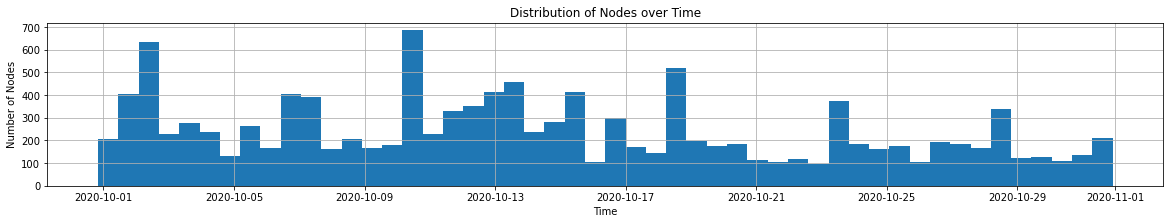

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.020834,HLN.BE,0.005998,Fouad Gandoul,0.012343,HLN.BE,0.000821,Fouad Gandoul,1.0,@HanneMareels Nauw contact dus waar je mee lag...
1,0.019714,De Morgen,0.003333,HLN.BE,0.009153,steven vermeylen,0.000414,HLN.BE,1.0,@Jelle290985 Afstand houden begrijpt men hier ...
2,0.019531,Arbiter,0.001910,PJ Van Leemputten,0.008596,De Morgen,0.000318,Joël De Ceulaer,1.0,@thebandb Vraag aan klas (4aso) na 10 dagen Q:...
3,0.018561,Joël De Ceulaer,0.001828,De Morgen,0.008590,Knack,0.000310,De Morgen,1.0,RT @vanranstmarc: Bekijk graag deze video.\nDi...
4,0.018551,Knack,0.001573,Arbiter,0.008522,N-VA,0.000278,CrisisCenter Belgium,1.0,"RT @NolfJan: ""De belangrijkste sleutel nog alt..."
5,0.017064,N-VA,0.001548,Joël De Ceulaer,0.007929,Karl Drabbe 🎗,0.000278,Sammy Mahdi,1.0,RT @vanranstmarc: Bekijk graag deze video.\nDi...
6,0.016148,CrisisCenter Belgium,0.001475,Knack,0.007913,Dirk Verhofstadt,0.000270,Arbiter,1.0,RT @vanranstmarc: Bekijk graag deze video.\nDi...
7,0.015524,Jan Jambon,0.001474,NMBS,0.007313,Dyab Abou Jahjah,0.000269,sporza,1.0,RT @peter_persyn: “We moeten het effect van de...
8,0.015082,Radio 1,0.001343,CrisisCenter Belgium,0.007305,Inge NWN®™‏,0.000262,Knack,1.0,@TomA3aenssens @Bouboutyassine Ik heb momentee...
9,0.014479,Sammy Mahdi,0.001169,Radio 1,0.006650,башлам,0.000262,zin om je tom helsen,1.0,RT @koendaniels: Respect tonen voor hulpverlen...


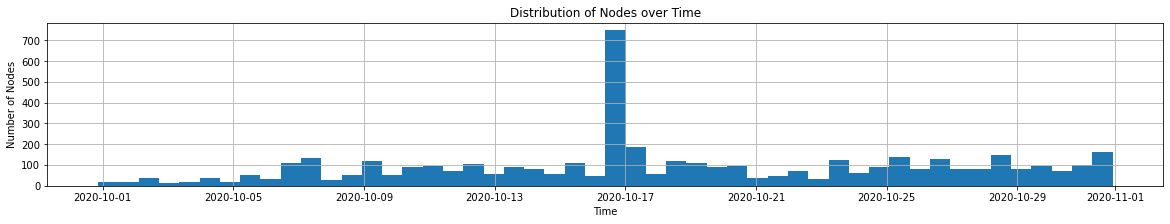

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000722,ᴮᴱNikita⁷ maskertje op,0.000312,ᴮᴱNikita⁷ maskertje op,0.000558,ᴮᴱNikita⁷ maskertje op,0.000070,M⁷☆,1.0,"@sandaengi Ooh, en ik zie ook al goede 1.5m en..."
1,0.000722,M⁷☆,0.000184,♡𝑺𝒖𝒅𝒆 𝒁𝒂𝒏𝒂🐺⁷/ BLM ACAB FREE🇵🇸,0.000361,🖤ᴸᶦᵉˢʲᵉ,0.000054,ᴮᴱNikita⁷ maskertje op,1.0,RT @yoongishugz: dit is niet goed????? de covi...
2,0.000463,hanna,0.000167,𝗻𝗮𝗼𝗺𝗶⁷,0.000216,Charlotte⁷,0.000040,hanna,1.0,@anouk_bts Ik had dat ook vorige week en de do...
3,0.000431,☆ annieʲᵏ,0.000160,RT @vic23: En toch zie ik in de horeca meer me...,0.000153,enya🍂🃏BLM,0.000037,Charlotte⁷,1.0,RT @dionysusnj: Waarom kunnen ze geen creatiev...
4,0.000409,Charlotte⁷,0.000126,M⁷☆,0.000142,Lachimolala⁷,0.000035,☆ annieʲᵏ,1.0,@qyoonkook Het aantal Karen's en oude mensen o...
5,0.000388,ᴮᴱnienke⁷,0.000112,Irene⁷⟭⟬,0.000141,sulky⁷,0.000034,Hadia⁷,1.0,RT @cloudychan_: Dus ik mag niet met mijn team...
6,0.000377,Hadia⁷,0.000102,Charlotte⁷,0.000118,ᴮᴱnienke⁷,0.000032,JJK⁷ 🗃️🧮,1.0,@3vaelisa HAHAHAHA\n\nnee maar serieus wij hou...
7,0.000366,JJK⁷ 🗃️🧮,0.000097,RT @httpchanie: Het is te gek voor woorden dit...,0.000107,\⁷ rereading ACOTAR| IREE DAY,0.000031,ᴮᴱnienke⁷,1.0,"@DlOR97KTH ja drm, maar horeca gaat wel dicht ..."
8,0.000356,ᴮᴱ rach⁷,0.000084,𝘪𝘭𝘰𝘯𝘢🧸♡ minho,0.000099,hanna,0.000030,♥Brave⁷.•,1.0,"@tilly12501 Nope, wel controle van de gemeente..."
9,0.000323,♥Brave⁷.•,0.000071,hanna,0.000095,Ann 🔥,0.000030,♡𝑺𝒖𝒅𝒆 𝒁𝒂𝒏𝒂🐺⁷/ BLM ACAB FREE🇵🇸,1.0,RT @debroervanroos: wacht. jongeren tot 18 jaa...


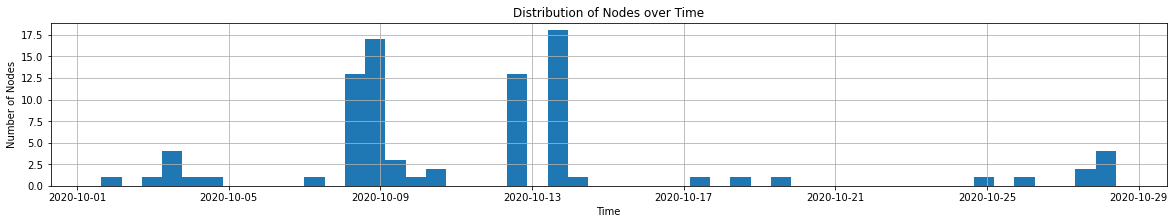

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000108,jimin day☆,0.000046,jay¹²⁽⁷⁾🎃 has xiaojun on his mind,6.988999e-05,jay¹²⁽⁷⁾🎃 has xiaojun on his mind,0.000017,jimin day☆,0.666667,elise △⃒⃘ ia bc school
1,0.000075,jay¹²⁽⁷⁾🎃 has xiaojun on his mind,0.000045,ᴮᴱɴɪᴋᴋɪ⁷ ♡'ꜱ ʜᴀᴘᴘʏ ᴍɪɴꜱᴜ,2.195703e-05,@fearlesswallss @knjsbutterfly Die 1.5 meter i...,0.000014,jay¹²⁽⁷⁾🎃 has xiaojun on his mind,0.600000,@fearlesswallss @knjsbutterfly Die 1.5 meter i...
2,0.000054,@fearlesswallss @knjsbutterfly Die 1.5 meter i...,0.000024,jimin day☆,2.192690e-05,@MarsL71002190 @knjsbutterfly de maatregelen m...,0.000011,ᴮᴱɴɪᴋᴋɪ⁷ ♡'ꜱ ʜᴀᴘᴘʏ ᴍɪɴꜱᴜ,0.500000,@MarsL71002190 @knjsbutterfly de maatregelen m...
3,0.000054,ᴮᴱɴɪᴋᴋɪ⁷ ♡'ꜱ ʜᴀᴘᴘʏ ᴍɪɴꜱᴜ,0.000004,@MarsL71002190 @knjsbutterfly de maatregelen m...,2.192690e-05,"@MarsL71002190 @knjsbutterfly dat bedoel ik, a...",0.000008,@fearlesswallss @knjsbutterfly Die 1.5 meter i...,0.500000,"@MarsL71002190 @knjsbutterfly dat bedoel ik, a..."
4,0.000043,@MarsL71002190 @knjsbutterfly de maatregelen m...,0.000004,@fearlesswallss @knjsbutterfly Die 1.5 meter i...,9.588067e-07,jimin day☆,0.000006,@MarsL71002190 @knjsbutterfly de maatregelen m...,0.200000,ᴮᴱɴɪᴋᴋɪ⁷ ♡'ꜱ ʜᴀᴘᴘʏ ᴍɪɴꜱᴜ
5,0.000043,"@MarsL71002190 @knjsbutterfly dat bedoel ik, a...",0.000004,"@MarsL71002190 @knjsbutterfly dat bedoel ik, a...",1.340417e-07,ᴮᴱɴɪᴋᴋɪ⁷ ♡'ꜱ ʜᴀᴘᴘʏ ᴍɪɴꜱᴜ,0.000006,"@MarsL71002190 @knjsbutterfly dat bedoel ik, a...",0.095238,jay¹²⁽⁷⁾🎃 has xiaojun on his mind
6,0.000032,elise △⃒⃘ ia bc school,0.000000,elise △⃒⃘ ia bc school,9.641874e-08,als iemand die in een supermarkt werkt moet ik...,0.000006,elise △⃒⃘ ia bc school,0.088889,jimin day☆
7,0.000011,als iemand die in een supermarkt werkt moet ik...,0.000000,als iemand die in een supermarkt werkt moet ik...,9.641874e-08,een klant wou gisteren in de winkel een vraag ...,0.000004,als iemand die in een supermarkt werkt moet ik...,NaN,als iemand die in een supermarkt werkt moet ik...
8,0.000011,een klant wou gisteren in de winkel een vraag ...,0.000000,een klant wou gisteren in de winkel een vraag ...,9.057454e-08,elise △⃒⃘ ia bc school,0.000004,een klant wou gisteren in de winkel een vraag ...,NaN,een klant wou gisteren in de winkel een vraag ...


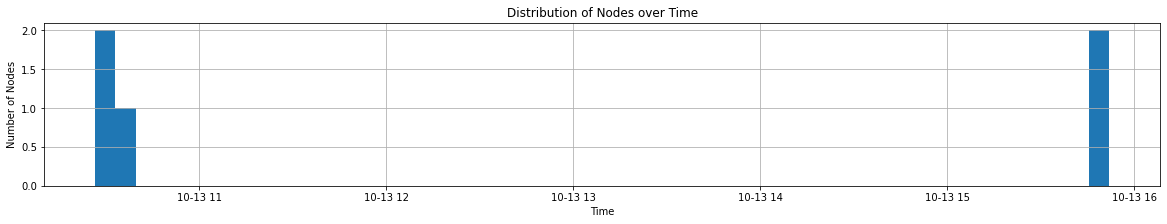

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000054,@willembrandt1 @Chippie07455336 @F_azarkan Sta...,0.000011,@willembrandt1 @Chippie07455336 @F_azarkan Sta...,5.141747e-06,@willembrandt1 @Chippie07455336 @F_azarkan Sta...,0.000007,@willembrandt1 @Chippie07455336 @F_azarkan Sta...,1.0,ikke
1,0.000054,@ikke64587087 @Chippie07455336 @F_azarkan Hoez...,0.000011,@ikke64587087 @Chippie07455336 @F_azarkan Hoez...,5.141747e-06,@ikke64587087 @Chippie07455336 @F_azarkan Hoez...,0.000007,@ikke64587087 @Chippie07455336 @F_azarkan Hoez...,1.0,willembrandt
2,0.000022,ikke,0.000000,ikke,1.419989e-08,ikke,0.000005,ikke,0.4,@willembrandt1 @Chippie07455336 @F_azarkan Sta...
3,0.000022,willembrandt,0.000000,willembrandt,1.419989e-08,willembrandt,0.000005,willembrandt,0.4,@ikke64587087 @Chippie07455336 @F_azarkan Hoez...


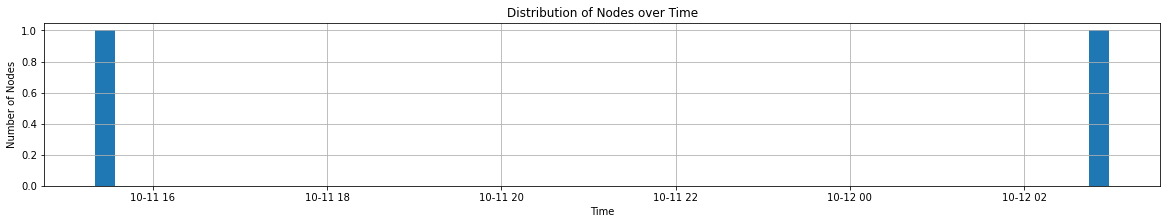

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')